In [2]:
# %load_ext snakeviz
import time
import numpy as np 
import pandas as pd
from ete3 import Tree, TreeStyle

# path = "/home/ivati/Documents/data_TiPS1/"
path = "/home/ivati/montages_reseau/backup/TEST_DATA/"
LARGE_SIZE = 901 # for tree of size between 405 and 900
SMALL_SIZE = 451 #500

In [3]:
params = pd.read_table(path+"test_params.csv", sep=" ")
print(len(params))
params

1142


mean_signal  amplitude  incubation_rate  recovery_rate  import_param  \
0        0.036708   4.871949         0.975978       0.064719      7.991196   
1        0.055743   2.287950         0.814976       0.072167      3.186711   
2        0.034184   3.899711         0.412017       0.056127      9.594347   
3        0.159451   0.516159         0.241024       0.167228      8.026138   
4        0.087196   1.497525         0.203607       0.059843      1.369252   
...           ...        ...              ...            ...           ...   
1137     0.046156   0.942149         0.731220       0.045655      9.137513   
1138     0.054837   1.738535         0.686527       0.060569      4.727576   
1139     0.109563   3.577464         0.058525       0.123450      4.924622   
1140     0.027896   5.144835         0.299834       0.037701      4.517524   
1141     0.246070   0.525819         0.121296       0.242735      8.232146   

      sampling_proba  
0                0.2  
1                0.2  
2                0.2  
3                0.2  
4                0.2  
...              ...  
1137             0.2  
1138             0.2  
1139             0.2  
1140             0.2  
1141             0.2  

[1142 rows x 6 columns]

In [31]:
# start = time.time()
# with open(path+"Trees.newick",'r') as f:
#     forest = f.readlines()
# print("Downloading forest took:", time.time()-start, 's')
# print(len(forest))

141289


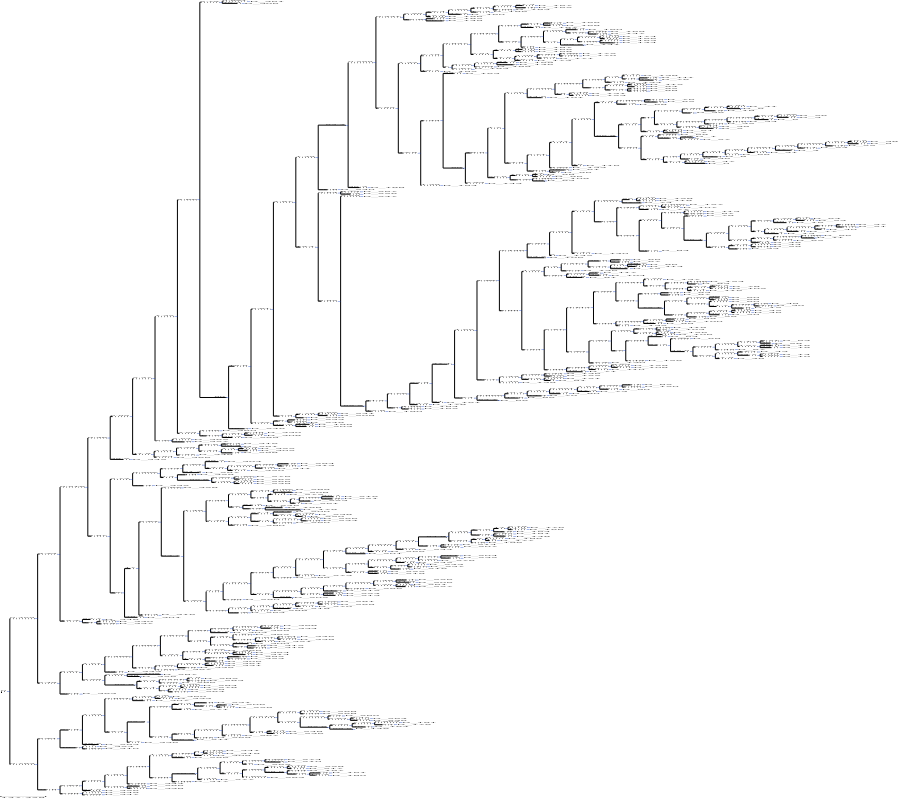

In [42]:
a_tree = Tree(forest[141285])
ts = TreeStyle()
ts.show_branch_length = True
a_tree.render(file_name="%%inline", w=900,h=800, tree_style=ts)

In [43]:
print(len(a_tree.get_leaves()))

363


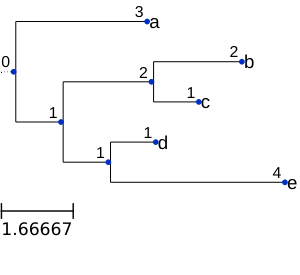

In [4]:
def rescale_tree(tree, target_avg_length=1):
    """
    Returns the rescaling factor and rescale the tree
    :params str_tree: string, newick tree on which we compute the rescaling factor is computed
    :params target_avg_length: float, the average branch length to which we want to rescale the tree
    :returns: float, resc_factor
    """    
    
    branch_lengths = [node.dist for node in tree.traverse()]
    resc_factor = np.mean(branch_lengths)/target_avg_length
    
    for node in tree.traverse():
        node.dist /= resc_factor
    
    return resc_factor


def ladderize(tre):
    """
    Tree ladderization: the branch supporting the most recently sampled subtree is rotated to the left
    :params tre: ete3 Tree, binary tree we want to ladderize
    :return: void, modified the tree tre
    """
    
    # feature to know which subtree is the most recent
    for node in tre.iter_descendants("postorder"):
        if node.is_leaf():
            node.add_feature('subtree_size', node.dist)
        else:
            children = node.children
            node.add_feature('subtree_size', node.dist + max(children[0].subtree_size, children[1].subtree_size))
            
    # swap children so that the most recent is on the left
    for node in tre.traverse():

        children = node.children #if node is leaf children==None
        if children:
            if children[0].subtree_size < children[1].subtree_size:
                node.swap_children()
                
    
            children[0].del_feature("subtree_size")
            children[1].del_feature("subtree_size")
            
            
def inorder_traverse(node, previous_node, root, vect_lf=[], vect_in=[]):
    """
    Tree traversal (standart recursive algorithm from the depth first family) and encoding
    Inorder tree walk (binary search tree)
    :param node: 
    :param previous_node:
    :param root:
    :param vect_lf:
    :param vect_in:
    :return: 
    """

    if node.is_root():
        node.add_feature('dist_to_root', 0)
        previous_depth = 0
    else:
        previous_depth = node.up.dist_to_root

    
    if not node.is_leaf(): # node has always 2 children, provided that it is not a leaf
        node.add_feature('dist_to_root', node.dist + previous_depth)
        
        inorder_traverse(node.children[0], previous_node, root, vect_lf=vect_lf, vect_in=vect_in)
        
        #for internal node, we add its distance to the root
        vect_in.append(node.dist_to_root)
        
        previous_node = node
        inorder_traverse(node.children[1], previous_node, root, vect_lf=vect_lf, vect_in=vect_in)
        
    else:
        #for tips, we add its distance to the previously visited node
        vect_lf.append(node.dist+previous_depth - previous_node.dist_to_root)

            
    return vect_lf, vect_in


def to_CBLV(tre, maxSize, sampling_p):
    """
    :param tree: ete3 tree, tree that we want to vectorize
    :param maxSize: int, dimension of the vector/NN input
    :return:
    """

    # Tree ladderization
    ladderize(tre)
    #print(tre.get_ascii("name"))
    # Get 
    # Encoding
    vect_lf, vect_in = inorder_traverse(tre, tre, tre, vect_lf=[], vect_in=[])
    
    # Zero-completion
    tree_vect = np.zeros((2, maxSize))
    tree_vect[0, :len(vect_lf)] = vect_lf
    tree_vect[1, :len(vect_in)] = vect_in
    
    tree_vect[:, -1] = [sampling_p]*2
    
    return tree_vect

# Check algorithm
test_tree = Tree("(a:3,((b:2, c)C:2, (d, e:4)D)B)A;", format=1)
ts = TreeStyle()
ts.show_branch_length = True
test_tree.render(file_name="%%inline", w=300,tree_style=ts)

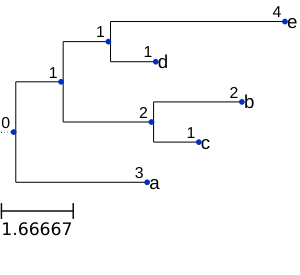

In [13]:
ladderize(test_tree)
test_tree.render(file_name="%%inline", w=300,tree_style=ts)

In [14]:
to_CBLV(test_tree, 8, 0.2)

array([[6. , 1. , 4. , 1. , 3. , 0. , 0. , 0.2],
       [2. , 1. , 3. , 0. , 0. , 0. , 0. , 0.2]])

The corresponding Compact Bijective Ladderized Vector is:
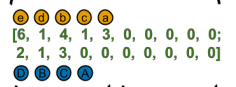

In [5]:
def transform_raw_data(param_file=path+"test_params.csv", trees_file=path+"test_Trees.newick",
                       vectors_file="test_CBLV.npy", new_params_file="test_scaled_params.csv",
                       factors_file="test_factors.npy"):
    """
    Remove label that leads to no tree 
    Rescale time dependent parameters in design
    Rescale tree in forest and turn each tree into his CBLV REPRESENTATION
    """
    
    #Load files
    params = pd.read_table(param_file, sep=" ")
    with open(trees_file,'r') as f:
        forest = f.readlines()

    params_to_scale = ['mean_signal', 'incubation_rate', 'recovery_rate'] #bêta, gamma et sigma are time dependent
    small_data_vect, large_data_vect = [], []
    small_scaled_params, large_scaled_params = pd.DataFrame(columns=params.columns), pd.DataFrame(columns=params.columns)
    small_resc_fact, large_resc_fact = [], []
    
    nb = len(forest)
    
    for i in range(nb):

        tree = Tree(forest[i])
        resc_fact = rescale_tree(tree) # tree is rescaled
        
        if len(tree.get_leaves()) < SMALL_SIZE:
            small_resc_fact.append(resc_fact) 
            
            small_scaled_params.loc[i] = params.loc[i]
            small_scaled_params.loc[i][params_to_scale] *= resc_fact #some corresponding parameters are scaled

            # stock CBLV representation
            small_data_vect.append(to_CBLV(tree, SMALL_SIZE, params.loc[i]['sampling_proba']))
            
        else:
            large_resc_fact.append(resc_fact) 
            
            large_scaled_params.loc[i] = params.loc[i]
            large_scaled_params.loc[i][params_to_scale] *= resc_fact #some corresponding parameters are scaled

            # stock CBLV representation
            large_data_vect.append(to_CBLV(tree, LARGE_SIZE, params.loc[i]['sampling_proba']))

    # Check shapes
    print(np.array(small_data_vect).shape)
    print(small_scaled_params.shape)
    print(np.array(small_resc_fact).shape)
    print(np.array(large_data_vect).shape)
    print(large_scaled_params.shape)
    print(np.array(large_resc_fact).shape)
    
    # save features and labels        
    np.save(path+"small_"+vectors_file, np.array(small_data_vect))
    np.save(path+"large_"+vectors_file, np.array(large_data_vect))
    small_scaled_params.to_csv(path+"small_"+new_params_file)
    large_scaled_params.to_csv(path+"large_"+new_params_file)
    
    # save rescale factors
    np.save(path+"small_"+factors_file, np.array(small_resc_fact))
    np.save(path+"large_"+factors_file, np.array(large_resc_fact))



st = time.time()
# small_vect, small_fact, small_param, large_vect, large_fact, large_param = transform_raw_data()
transform_raw_data()
print('Conversion took', (time.time()-st)/60, 'min')
# %snakeviz transform_raw_data()

(439, 2, 451)
(439, 6)
(439,)
(703, 2, 901)
(703, 6)
(703,)
Conversion took 0.3549195647239685 min


In [47]:
# params_to_scale = ['mean_signal', 'incubation_rate', 'recovery_rate'] #bêta, gamma et sigma are time dependent
# small_data_vect, large_data_vect = [], []
# small_scaled_params, large_scaled_params = pd.DataFrame(columns=params.columns), pd.DataFrame(columns=params.columns)
# small_resc_fact, large_resc_fact = [], []
# nb = len(forest)

# for i in range(nb):

#     tree = Tree(forest[i])

#     if len(tree.get_leaves()) <= 451 :
#         resc_fact = rescale_tree(tree) # tree is rescaled
#         small_resc_fact.append(resc_fact) 

#         small_scaled_params.loc[i] = params.loc[i]
#         small_scaled_params.loc[i][params_to_scale] *= resc_fact #some corresponding parameters are scaled

#         # stock CBLV representation
#         small_data_vect.append(to_CBLV(tree, SMALL_SIZE, params.loc[i]['sampling_proba']))

#     else:
#         resc_fact = rescale_tree(tree) # tree is rescaled
#         large_resc_fact.append(resc_fact) 

#         large_scaled_params.loc[i] = params.loc[i]
#         large_scaled_params.loc[i][params_to_scale] *= resc_fact #some corresponding parameters are scaled

#         # stock CBLV representation
#         large_data_vect.append(to_CBLV(tree, LARGE_SIZE, params.loc[i]['sampling_proba']))

# print(np.array(small_data_vect).shape)
# print(small_scaled_params.shape)
# print(np.array(small_resc_fact).shape)
# print(np.array(large_data_vect).shape)
# print(large_scaled_params.shape)
# print(np.array(large_resc_fact).shape)

(54653, 2, 451)
(54653, 6)
(54653,)
(86636, 2, 901)
(86636, 6)
(86636,)


In [38]:
46795+94494

141289

In [50]:
# param_file=path+"params_TiPS.csv"
# trees_file=path+"Trees_TiPS.newick"
# vectors_file="CBLV_TiPS.npy"
# new_params_file="scaled_params_TiPS.csv"
# factors_file="factors_TiPS.npy"
        
# # save features and labels        
# np.save(path+"small_"+vectors_file, np.array(small_data_vect))
# np.save(path+"large_"+vectors_file, np.array(large_data_vect))
# small_scaled_params.to_csv(path+"small_"+new_params_file)
# large_scaled_params.to_csv(path+"large_"+new_params_file)

# # save rescale factors
# np.save(path+"small_"+factors_file, np.array(small_resc_fact))
# np.save(path+"large_"+factors_file, np.array(large_resc_fact))

In [39]:
small_scaled_params

mean_signal  amplitude  incubation_rate  recovery_rate  import_param  \
1          0.317530   6.078997        12.503203       0.877623      5.925867   
6          1.805685   4.493246         1.240348       2.458854      0.220452   
9          4.044080   0.580377         1.323978       4.933744      2.884404   
12         2.549494   0.856607         1.344341       4.067515      9.412988   
19         3.331323   0.935296         1.246963       3.256261      4.604196   
...             ...        ...              ...            ...           ...   
141277     0.647710   3.356027         4.105314       1.096430      6.899124   
141281     0.918657   1.706573         7.460460       1.002856      7.139806   
141284     1.135888   0.505539         6.735175       1.272784      6.347687   
141285     2.794445   1.437302         1.111802       2.906453      3.523878   
141288     0.546958   4.669773         8.858522       0.875253      3.321633   

        sampling_proba  
1                  0.2  
6                  0.2  
9                  0.2  
12                 0.2  
19                 0.2  
...                ...  
141277             0.2  
141281             0.2  
141284             0.2  
141285             0.2  
141288             0.2  

[46795 rows x 6 columns]